In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [4]:
'''Import Data'''
data = pd.read_csv('./test-data/clm-hillslope-data.csv', index_col = [0])

data.head()

,observed_Q,basin_ppt,basin_tmin,basin_tmax,model_Q,basin_soil_moist,basin_snowmelt,basin_actet,basin_potet
0,0.0,0.0,255.68925,255.96611,-0.000003,1.010757,36.570500,0.0,0.0
1,0.0,0.0,263.14490,263.31420,-0.000003,1.010345,37.233820,0.0,0.0
2,0.0,0.0,257.18478,257.24280,-0.000003,1.006177,37.728703,0.0,0.0
3,0.0,0.0,265.92532,265.99603,-0.000003,1.004947,39.020004,0.0,0.0
4,0.0,0.0,249.01566,249.08228,-0.000003,0.999792,40.448044,0.0,0.0


c:\Users\marie\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\marie\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\marie\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\marie\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

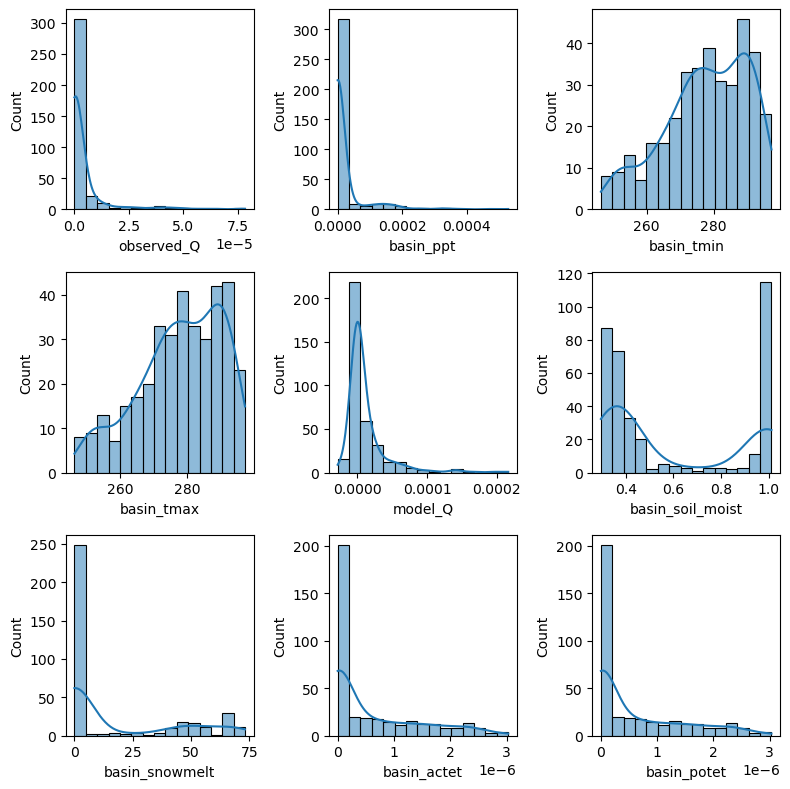

In [22]:
'''Distribution plots'''
fig, axs = plt.subplots(3, 3, figsize = (8, 8), 
                    layout = 'tight')

for i in range(0, 9):
    ax = axs.ravel()[i]

    sns.histplot(x = data.iloc[:, i], bins = 15, kde = True, ax = ax)

In [222]:
'''Functions'''

#Generate probability distribution
def pdf(dat, bins = 15):
    #dat - data for which the pdf is to be derived
    #bins - number of histogram bins, bins are generally set to 15 given the results of
    #  optimization methods described in Ruddell & Kumar 2009
    hist, _ = np.histogram(dat,  bins = bins)
    n = len(dat)
    return hist/n

#Joint probability distribution
def jpdf(dats, bins = 15):
    #dats - columns of data for which the pdf is to be derived
    #bins - number of histogram bins, bins are generally set to 15 given the results of
    #  optimization methods described in Ruddell & Kumar 2009
    hist, _ = np.histogramdd(np.array(dats), bins = bins)
    return hist/hist.sum()

#Calculate Entropy
def entropy(dat):
    #dat - data for which the entropy is to be calculated
    probs = pdf(dat)
    h = -np.nansum([p*np.log2(p) for p in probs])
    return h

#Calculate Joint Entropy
def jentropy(dats):
    #dat - data for which the entropy is to be calculated
    probs = jpdf(dats)
    h = -np.nansum(np.nansum([p*np.log2(p) for p in probs]))
    return h

#Calculate Mutual Information
def mi(dats):
    #dats - two column data to compute mutual information
    return entropy(np.array(dats.iloc[:, 0])) + entropy(np.array(dats.iloc[:, 1])) - jentropy(np.array(dats))


#Calculate transfer entropy
def te(x, y, lag = 1):
    #x - x data to be used for the transfer entropy computation
    #y - y data to be used for the transfer entropy computation
    #lag - temporal lag that will be used to shift the X series

    #X_(t - \tau\delta_t)
    shiftedX = x[: len(x) - lag].reset_index(drop = True)
    #Y_(t - \delta_t)
    shiftedY = y[lag - 1 : len(x) - 1].reset_index(drop = True)
    #cut y
    cutY = y[lag:].reset_index(drop = True)
    
    #Check lengths are the same
    if((len(shiftedX) != len(shiftedY)) or(len(shiftedY) != len(cutY))):
        return "Lengths not equal, something went wrong"
    else:
        p1 = pd.DataFrame([shiftedX, shiftedY]).T
        p2 = pd.DataFrame([cutY, shiftedY]).T
        p3 = shiftedY
        p4 = pd.DataFrame([shiftedX, cutY, shiftedY]).T
        return jentropy(p1) + jentropy(p2) - entropy(p3) - jentropy(p4)
    
#Transfer Entropy with Significance Test
def te_test(x, y, lag = 1, n = 100, alpha = 0.05):
    #x - x data to be used for the transfer entropy computation
    #y - y data to be used for the transfer entropy computation
    #lag - temporal lag that will be used to shift the X series
    #n - number of MCMC iterations to run

    #testable te
    t = te(x, y, lag = lag)

    #randomly scramble data
    tss = []
    for i in range(0, n):
        #compute shuffled transfer entropy
        xss = x
        random.shuffle(xss)
        yss = y
        random.shuffle(yss)
        tss.append(te(xss, yss, lag = lag))

    #fit gaussian
    mean = np.mean(tss)
    sd = np.std(tss)

    #test
    if(alpha == 0.01):
        Tz = mean + 2.36*sd
    elif(alpha == 0.05):
        Tz = mean + 1.66*sd
    else:
        return "Only capable of computing 95% (alpha = 0.05) and 99% (alpha = 0.01) one tail distributions."
    
    return t, Tz, t > Tz

    

In [232]:
#Test
t = []
tz = []
sig = []
lags = range(1, 100)

for l in lags:
    a, b, c = te_test(data.iloc[:, 1], data.iloc[:, 0], lag = l)
    t.append(a)
    tz.append(b)
    sig.append(c)

In [ ]:
te_data = pd.DataFrame({"t" : t ,
                        "tz" : tz,
                        "significance" : sig, 
                        "delay" : lags})

c:\Users\marie\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\marie\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\marie\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\marie\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

Text(0, 0.5, 'Transfer Entropy')

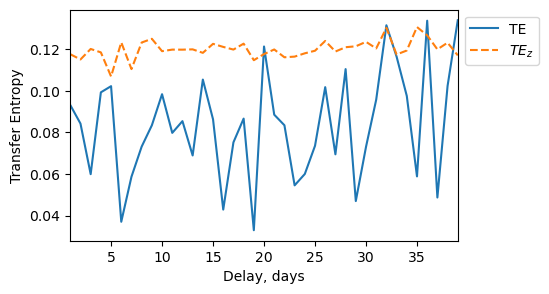

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (5, 3))

sns.lineplot(data = te_data, x = 'delay', y = 't', label = 'TE', ax = ax)
sns.lineplot(data = te_data, x = 'delay', y = 'tz', linestyle = '--', label = r'$TE_z$', ax = ax)

ax.legend(bbox_to_anchor = (1, 1))
ax.set_xlim(1, 39)
ax.set_xlabel('Delay, days')
ax.set_ylabel('Transfer Entropy')